In [1]:
#  Data manipulation & visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Model building & evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#  NLP libraries: spaCy 
import spacy
nlp = spacy.load("en_core_web_sm")

sns.set()

In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 144.6 kB/s eta 0:01:25
     - ------------------------------------- 0.5/12.8 MB

In [3]:
# Load the balanced reviews dataset
df = pd.read_csv('imbalanced_reviews_dataset3.csv')
#display the balanced dataset
df

,reviewerID,asin,reviewerName,helpful,reviewText,Rating,summary,reviewTime,review_length
0,A24QAEZCNUTJ3N,B0090R20R0,J. Danzig,"[0, 0]",stays dry holds phone with case and has a good...,4,Great product,"10 28, 2013",79
1,AY28L9U9QA9RJ,B00CXKS1CO,"Amazon Shopping Mom ""Mom of 3""","[1, 1]",i needed a new back for my galaxy s4 i missed ...,3,Do NOT purchase if you want to use a protectiv...,"02 18, 2014",50
2,ARR5K9XBQ2HAU,B00ICXS0ZY,Sohrab,"[0, 0]",missed the markdoes not pair easily always a g...,2,Stopped using it,"07 16, 2014",36
3,A4DCJ0XSKGBK7,B008LFTCAK,"D. Hefler ""Toyman2""","[0, 0]",no matter what i did installing the protector ...,3,Works OK,"07 29, 2013",59
4,A14XT7FSP1U5AD,B005FVNHBI,Ed G,"[1, 1]",youd think jabra would have bluetooth down by ...,3,Just OK,"10 12, 2012",119
...,...,...,...,...,...,...,...,...,...
9995,A2PPAI9UI4KSGV,B004I8WD7S,Christian Macchio,"[0, 0]",this product protects iphone 4s very well i li...,4,Good protection,"02 12, 2013",20
9996,A3FOSLM5G1BO63,B0094CX4KS,"Eugene Tenenbaum ""reluctant reader""","[1, 1]",the belkin shield blooms case cover is light r...,4,Practical and aesthetic,"02 19, 2013",143
9997,A1IP2S3Z5LMDRN,B008M2ERV6,Tj,"[0, 0]",everyone really liked the wallet one thing mis...,4,Nice gave to my son in law,"06 19, 2013",24
9998,A3HOAITBTLRMIQ,B007TCZS7C,ShojoBakunyu,"[3, 4]",super thin film is impossible to apply without...,1,"Total waste of time and money, little though i...","10 1, 2012",73


In [4]:
#shape of the dataset
df.shape

(10000, 9)

In [5]:
#checking if there is any null values present
df.isnull().sum()

reviewerID       0
asin             0
reviewerName     0
helpful          0
reviewText       0
Rating           0
summary          0
reviewTime       0
review_length    0
dtype: int64

In [6]:
#checking for the duplicate values
df.duplicated().sum()

0

In [7]:
#display 3 full sample reviews per rating
for rating in sorted(df['Rating'].unique()):
    print(f"\n⭐ Rating {rating}")
    reviews = df[df['Rating'] == rating].tail(3)
    for _, row in reviews.iterrows():
        print(f"\n- {row['reviewText']}\n")


⭐ Rating 1

- leather wallet flip caseif you read the description its fake leather thats somewhat misleading to begin with i just received this item and its not even fake leatherits rubber rubber is not leather nor fake leatherthe speaker slot cutout doesnt actually line up with the speaker at allall that aside its a decent case not great but decentupdate ive lowered this to one star as it cant even be removed ive been fighting with this case for a half hour and managed to scratch the phone crack the case but not budge it in the slightest impressive in its own way but not good


- i used this device for a week and it failedi am unsure if this will work with an iphone 5 some features do not work like volume and telephoneluckily sending it back for a refund was easythe fit on the head is a bit strange but manageable had the headset worked


- super thin film is impossible to apply without many bubblesive applied window film that was easier than this stuff so im not some noob that doesnt

In [8]:
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split()))

In [9]:
#display the statistics of the word count
min_word_counts = df.groupby('Rating')['word_count'].describe()
print(min_word_counts)

         count       mean        std  min   25%   50%     75%    max
Rating                                                              
1       1000.0  62.700000  54.246296  5.0  27.0  43.0   76.00  344.0
2       1500.0  78.630667  68.952185  4.0  31.0  51.0   99.25  347.0
3       2500.0  74.358800  65.506507  4.0  29.0  49.0   96.00  350.0
4       3000.0  81.103000  70.985013  5.0  29.0  53.0  109.00  350.0
5       2000.0  68.890500  65.665786  4.0  26.0  42.0   84.00  349.0


## Data Visualisation
### Bar graph for Rating distribution

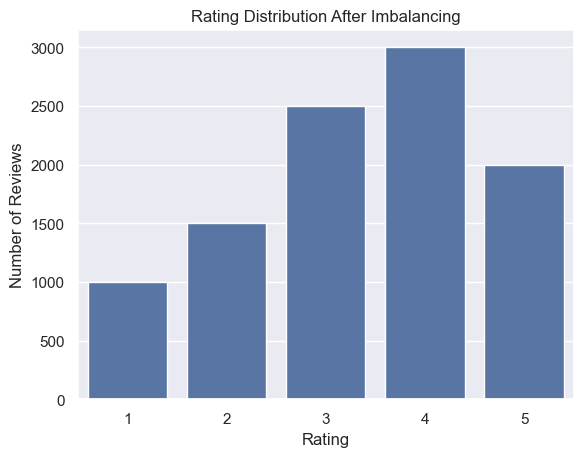

In [11]:
sns.countplot(x='Rating', data=df)
plt.title("Rating Distribution After Imbalancing")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

###  Review Length Distribution using Histogram

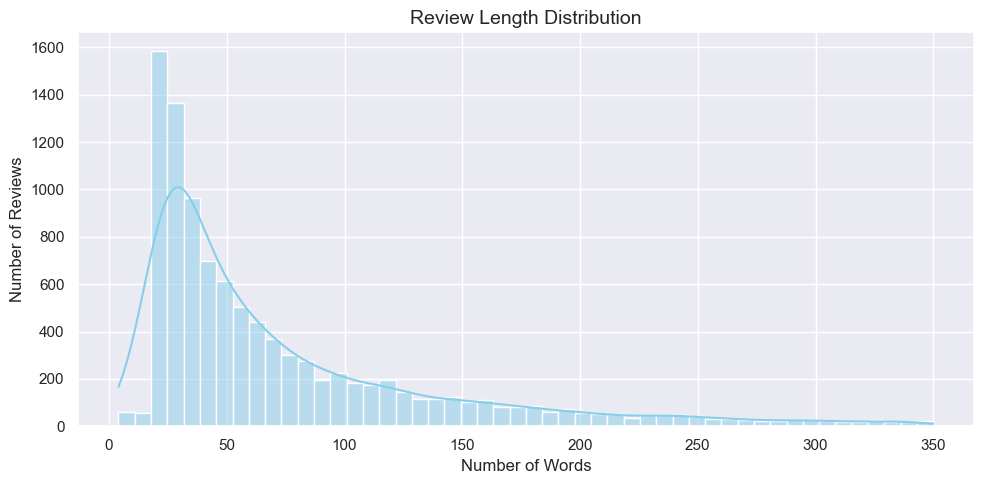

In [13]:
# Visualize the distribution of review lengths (number of words per review)

plt.figure(figsize=(10, 5))  # Set the size of the plot

# Create a histogram of review lengths with a KDE (smoothed line)
sns.histplot(data=df, x='review_length', bins=50, kde=True, color='skyblue')

# Add titles and axis labels
plt.title("Review Length Distribution", fontsize=14)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)

# Improve layout and display the plot
plt.tight_layout()
plt.show()

###  Visualize rating distribution using a pie chart


In [15]:
# Count the number of reviews per rating (sorted by rating value)
rating_counts = df['Rating'].value_counts().sort_index()

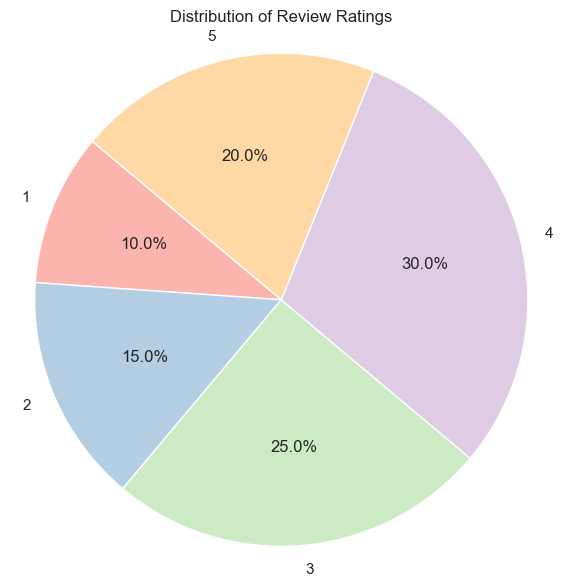

In [16]:
# Labels for pie slices (e.g., '1', '2', ..., '5')
labels = rating_counts.index.astype(str)
#Corresponding values (number of reviews per rating)
sizes = rating_counts.values

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Review Ratings')
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.show()

## Train-Test-Split

In [18]:
#  Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'],df['Rating'], test_size=0.2, random_state=42,stratify=df['Rating'] )

### Lemmatization and Stopword Removal

In [20]:
def spacy_preprocess(text):
    """
    Preprocess text using spaCy:
    - Tokenize the text
    - Remove stopwords and space tokens using spaCy
    - Lemmatize using spaCy

    Args:
        text (str): Input text

    Returns:
        str: Cleaned and lemmatized text
    """
    # Process the text using spaCy
    doc = nlp(text)

    # Filter and lemmatize
    tokens = [
        token.lemma_                      # spaCy lemmatization
        for token in doc
        if not token.is_stop and         # spaCy stopword removal
           not token.is_space and
           token.is_alpha                # Keep only alphabetic words (optional)
    ]

    return ' '.join(tokens)


In [21]:
#print the list of stopwords 
print(sorted(nlp.Defaults.stop_words))
# Print total number of unique stopwords in spaCy's English model
print("Number of spaCy stopwords:", len(nlp.Defaults.stop_words))


["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'ca', 'call', 'can', 'cannot', 'could', 'did', 'do', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', 'hence', 'her', 'here', 'he

In [22]:
# Apply stopword removal and lemmatization to the training and test text data

# Apply preprocessing to each review in the training set
X_train = X_train.apply(spacy_preprocess)

# Apply preprocessing to each review in the test set
X_test = X_test.apply(spacy_preprocess)


In [23]:
#shows the stopword removal and lemmatized text 
print(X_train.sample(5).values)

['personally not product apply properly phone ease likely simply function fact idea apply iti clean screen soft cloth pull protection piece place not straight pull slightly cause dust particle fill dust air bubble throw product look like work fine apply properly major product ease use'
 'sturdy smooth tip work great phone use actually wear fiber need replace hand issue need long stylus long one find reasonable cost work pen come handy'
 'love mount work great stay place complaint phone tilt probably case magnet'
 'case not want change far well great case'
 'realize short stylus like connect phone will not lose come use earbud']


In [24]:
# Initialize and fit TF-IDF on training only
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
# Transform test using the same fitted vectorizer
X_test_tfidf = tfidf.transform(X_test)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid2 = {
    'C': [0.01, 0.1, 1, 10],              # Inverse of regularization strength
    'penalty': ['l2'],                    # L1 and L2 are regularization methods
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [100, 200, 500]           # Number of iterations to converge
}

# Initialize the base model
log_reg = LogisticRegression(multi_class='auto', random_state=42)

# Grid Search with cross-validation
grid_search2 = GridSearchCV(log_reg, param_grid2, scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)
grid_search2.fit(X_train_tfidf, y_train)

# Best model
best_model2 = grid_search2.best_estimator_

# Evaluate
y_pred2 = best_model2.predict(X_test_tfidf)
print(classification_report(y_test, y_pred2))


Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\TOSHIBA\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.58      0.35      0.44       200
           2       0.40      0.25      0.31       300
           3       0.36      0.42      0.39       500
           4       0.43      0.54      0.48       600
           5       0.51      0.45      0.47       400

    accuracy                           0.43      2000
   macro avg       0.45      0.40      0.42      2000
weighted avg       0.44      0.43      0.42      2000



C:\Users\TOSHIBA\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


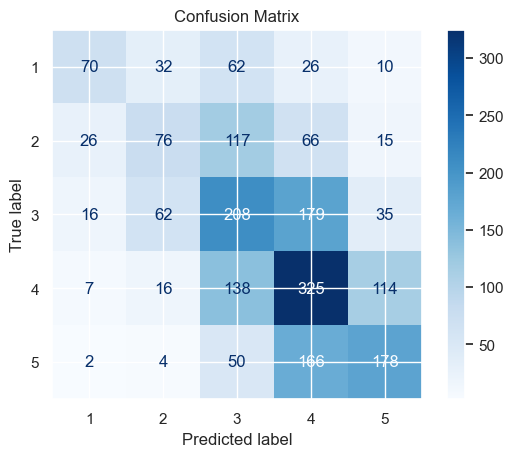

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred2, labels=sorted(y_test.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [49]:
import joblib

# Save the trained model
joblib.dump(best_model2, 'Model_B.pkl')  # or Model_B.pkl for imbalanced one

# Save the fitted vectorizer
joblib.dump(tfidf, 'TfidfVectorizer_b.pkl')


['TfidfVectorizer_b.pkl']

In [51]:
# Load balanced model and its TF-IDF vectorizer
model_A = joblib.load("Model_A.pkl")
tfidf_A = joblib.load("TfidfVectorizer.pkl")

In [53]:
X_test_tfidf_imbalanced_for_balanced_model = tfidf_A.transform(X_test)

In [57]:
y_pred_modelA_on_imbalanced = model_A.predict(X_test_tfidf_imbalanced_for_balanced_model)

In [67]:
from sklearn.metrics import classification_report, confusion_matrix

print("Evaluation of balanced Model on imbalanced Test Set:")
print(classification_report(y_test, y_pred_modelA_on_imbalanced))


Evaluation of balanced Model on imbalanced Test Set:
              precision    recall  f1-score   support

           1       0.35      0.64      0.45       200
           2       0.31      0.32      0.31       300
           3       0.47      0.34      0.39       500
           4       0.50      0.40      0.44       600
           5       0.47      0.57      0.52       400

    accuracy                           0.43      2000
   macro avg       0.42      0.45      0.42      2000
weighted avg       0.44      0.43      0.43      2000



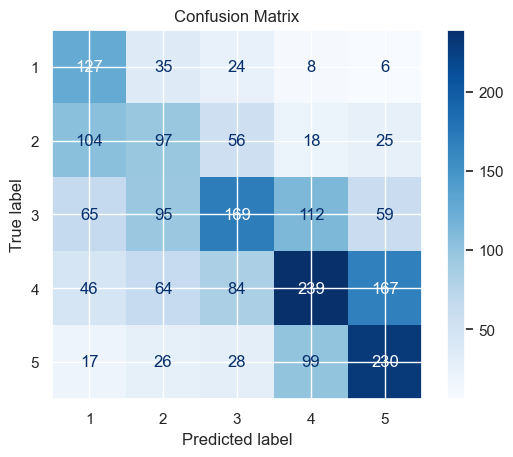

In [65]:
cm = confusion_matrix(y_test, y_pred_modelA_on_imbalanced, labels=sorted(y_test.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()